In [1]:
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
#print(plt.style.available)

In [403]:
import utils
import plotting
import helper
import models
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)

from helper import *
from utils import *
from analytical_solutions import *

In [13]:
import torchdiffeq

In [3]:
device = get_device()
set_seed()

Using the CPU


In [319]:
## Deprecated ##
class RNN(torch.nn.Module):
    def __init__(self,dim,hidden=10):
        super(RNN,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim,hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden,dim),
        )
    def forward(self,x):
        return self.net(x)
class ResRNN(torch.nn.Module):
    def __init__(self,dim,hidden=10):
        super(RNN,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim,hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden,dim),
        )
    def forward(self,x):
        return x + self.net(x)

# Learning the pendulum in theta-space

Firstly, we make a dataset of the pendulum trajectory.

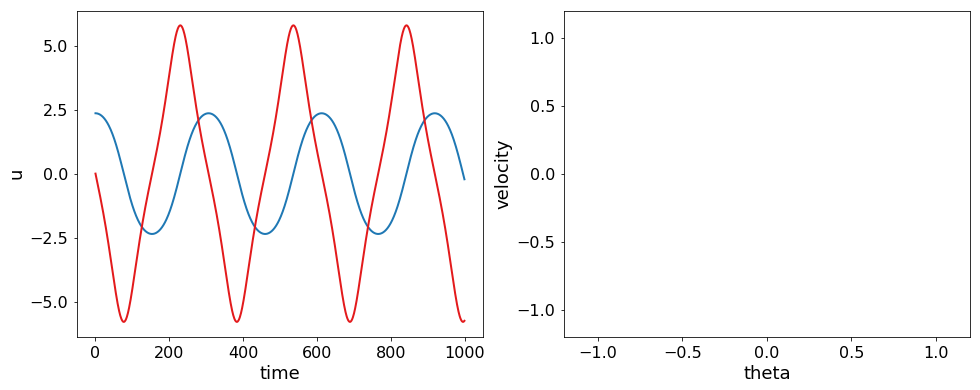

In [355]:
t_max = 10
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0,t_max,N_time_step)
data = solution_pendulum_theta(anal_ts, 1.5*np.pi/2)
plotting.trajectory_plots([data])

In [375]:
torch_ts = data_to_torch(anal_ts,device).reshape(-1,1)
torch_data = data_to_torch(data,device).reshape(-1,1,data.shape[-1])

In [377]:
class PendulumForceTheta(torch.nn.Module):
    def __init__(self):
        super(PendulumForceTheta,self).__init__()
    def forward(self,t, State):
        theta, v = State[:,0], State[:,1]
        g = -9.81
        return torch.stack([
            v,
            g*torch.sin(theta),
        ],dim=-1)

In [378]:
FTrue = PendulumForceTheta()

In [379]:
def solve_and_plot(model, method='rk4', idcs=0):
    with torch.no_grad():
        pred = torchdiffeq.odeint(model, torch_data[0,:], torch_ts, method=method)
    ts= torch_ts.cpu().numpy()
    plt.plot(ts, torch_data.detach().cpu().numpy()[:,idcs], '--')
    plt.plot(ts, pred.detach().cpu().numpy()[:,idcs])

(-6, 6)

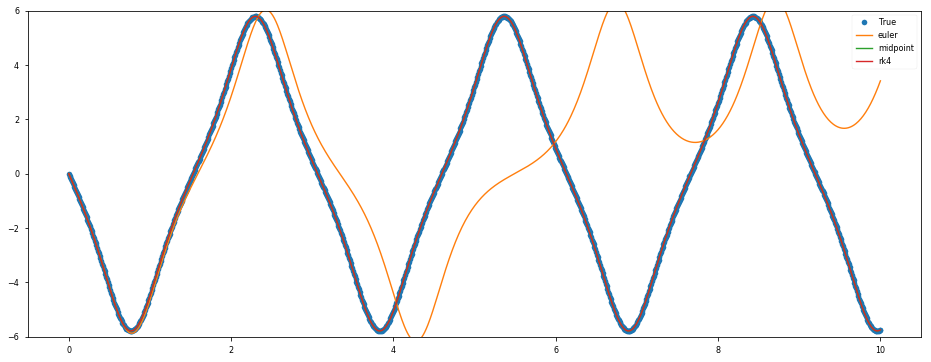

In [396]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.plot(anal_ts,data[:,1],'o',label='True')
with torch.no_grad():
    for m in ['euler','midpoint','rk4']:#,'dopri5']:
        pred = torchdiffeq.odeint(FTrue, torch_data[0,:], torch_ts, method=m)
        plt.plot(anal_ts,pred.detach().cpu().numpy().reshape(-1,2)[:,1],label=m)
plt.legend()
plt.ylim(-6,6)

In [59]:
class ODE_Func(torch.nn.Module):
    def __init__(self,dim,hidden=10):
        super(ODE_Func,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim,hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden,dim),
        )
    def forward(self,t,x):
        return self.net(x)

## These are the representative models

In [401]:
rnn = models.ShallowNet(2,2,50).double().to(device)
skiprnn = models.ShallowSkipNet(2,50).double().to(device)
ode_nerual = models.ShallowODE(2,50).double().to(device)
ode_multi = models.ShallowODE(2,50).double().to(device)

First, we try the NN types

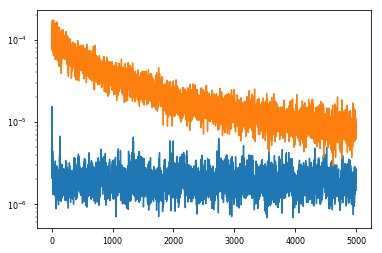

In [408]:
_,losses = learn_rnn(torch_data, rnn, device=device, N_iter=5000)
plt.semilogy(losses)
_,losses = learn_rnn(torch_data, skiprnn, device=device, N_iter=5000)
plt.semilogy(losses)

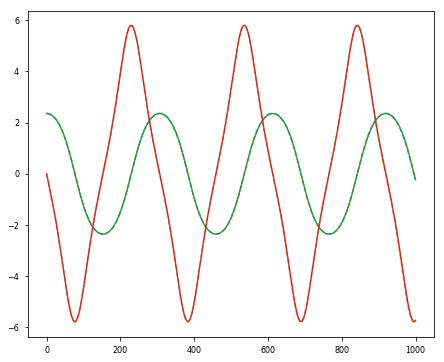

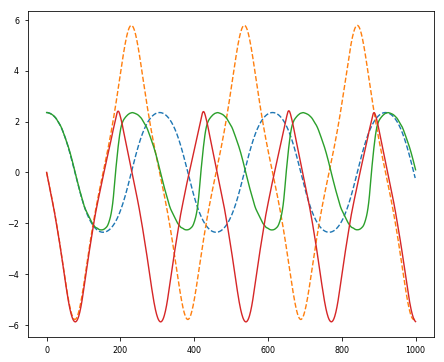

In [420]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
y0 = torch_data[0,:]#data_to_torch([2.5,0],device=device)
ys_rnn = integrate_model(rnn,y0, 1000)
ys_resrnn = integrate_model(skiprnn,y0, 1000)
def plotem(ys):
    plt.subplot(1,2,1)
    plt.plot(data,'--')
    plt.plot(ys[:,0])
    plt.plot(ys[:,1])
plotem(ys_rnn)
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plotem(ys_resrnn)

# Learning the pendulum in xy space

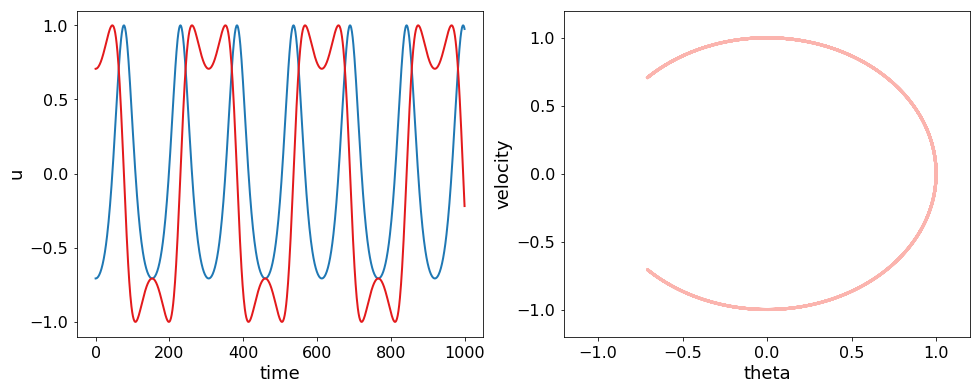

In [4]:
t_max = 10
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0,t_max,N_time_step)
data = solution_pendulum_xy(anal_ts, 1.5*np.pi/2)
plotting.trajectory_plots([data])

In [57]:
torch_ts = data_to_torch(anal_ts,device)#.reshape(-1,1)
torch_data = data_to_torch(data,device)#.reshape(-1,1,data.shape[-1])

## Solve it with an known ODE formula

We have older and trusted libraries for integrating odes, but using torchdiffeq just holds all things equal. The constraint force $f$ is derived from the formula $v\cdot n = 0$ which implies $\dot{\overline{v\cdot n}}=a\cdot n + v\cdot v=0$, yielding,
\begin{equation}
f = v\cdot v + g\cdot n
\end{equation}
Because of the constraint, this becomes a stiff equation.

In [364]:
class PendulumForceXY(torch.nn.Module):
    def __init__(self):
        super(PendulumForceXY,self).__init__()
    def forward(self,t, State):
        x,y,vx,vy = State[:,0], State[:,1], State[:,2], State[:,3]
        nx, ny = -x, -y
        gx, gy = -9.81, 0
        f = (vx*vx + vy*vy) + (gx*nx + gy*ny)
        return torch.stack([
            vx,
            vy,
            f*nx-gx,
            f*ny-gy,
        ],dim=-1)

In [352]:
FTrue = PendulumForceXY()

(-2, 2)

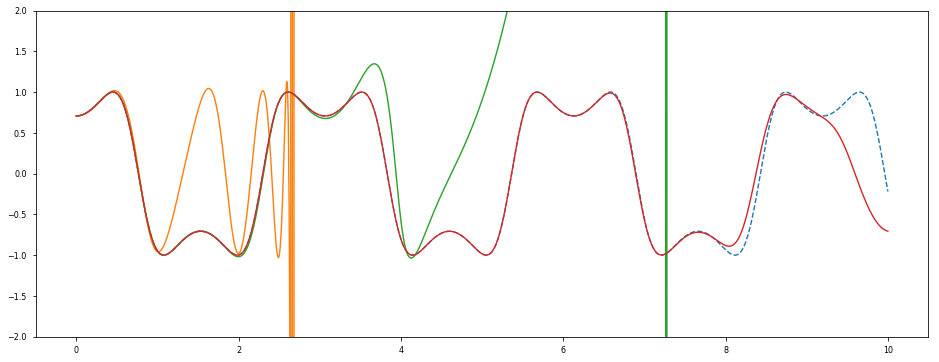

In [354]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.plot(anal_ts,data[:,1],'--')
with torch.no_grad():
    for m in ['euler','midpoint','rk4']:#,'dopri5']:
        pred = torchdiffeq.odeint(FTrue, torch_data[0:1,:], torch_ts, method=m)
        plt.plot(anal_ts,pred.detach().cpu().numpy().reshape(-1,4)[:,1:2])
plt.ylim(-2,2)

Note how the traditional ODE solvers don't do a very good job with this stiff formulation. This is well understood, even though we had hoped for a little better.

## Learn a discrete RNN

Using the CPU


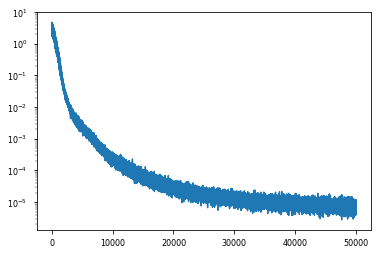

In [321]:
model_rnn = RNN(4,hidden=50).double()
_,losses = learn_rnn(torch_data, model_rnn, N_iter=50000)
plt.semilogy(losses)

Using the CPU


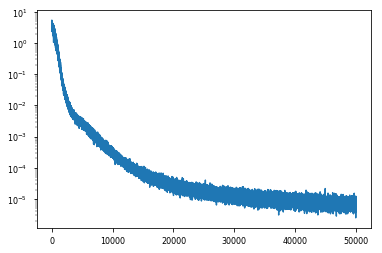

In [320]:
model_resrnn = RNN(4,hidden=50).double()
_,losses = learn_rnn(torch_data, model_resrnn, N_iter=50000)
plt.semilogy(losses)

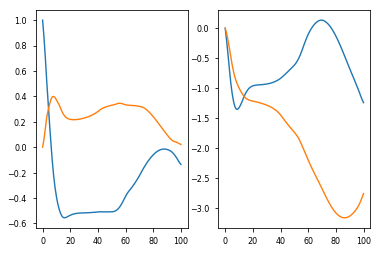

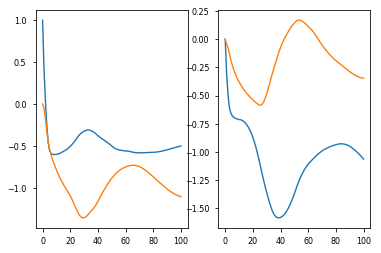

In [363]:
y0 = data_to_torch([1,0,0,0],device=device)
ys_rnn = integrate_model(model_rnn,y0, 100)
ys_resrnn = integrate_model(model_resrnn,y0, 100)
def plotem(ys):
    plt.subplot(1,2,1)
    plt.plot(ys[:,0])
    plt.plot(ys[:,1])
    plt.subplot(1,2,2)
    plt.plot(ys[:,2])
    plt.plot(ys[:,3])
plotem(ys_rnn)
plt.figure()
plotem(ys_resrnn)

## Learn a Neural ODE

In [96]:
def train_a_neural_ode(data, ts, model=None, batch_size=25, n_future=1, 
                       learning_rate = 1.0e-4, N_iter = 50000,
                       verbose=False, device=None, method='euler'):
    if device is None:
        device = get_device()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    N_print, N_trace = N_iter, 100
    for itr in range(1, N_iter):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch(data, ts,
                                               batch_size, n_future)
        pred_y = torchdiffeq.odeint(model, batch_y0, batch_t,
                                    method=method)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        if itr % 1000 == 0:
            with torch.no_grad():
                pred_y = torchdiffeq.odeint(model, batch_y0, batch_t)
                loss = torch.mean(torch.abs(pred_y - batch_y))
    return model,np.array(losses)

In [136]:
model_neuralode=ODE_Func(4, hidden=50).double().to(device)

In [137]:
model_neuralode,losses = train_a_neural_ode(torch_data,torch_ts, model=model_neuralode, device=device, batch_size=25, method='euler')

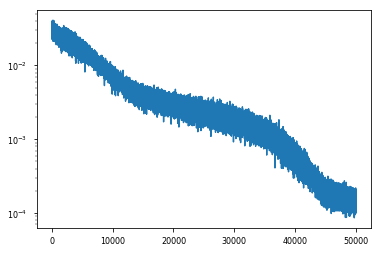

In [138]:
plt.semilogy(losses)

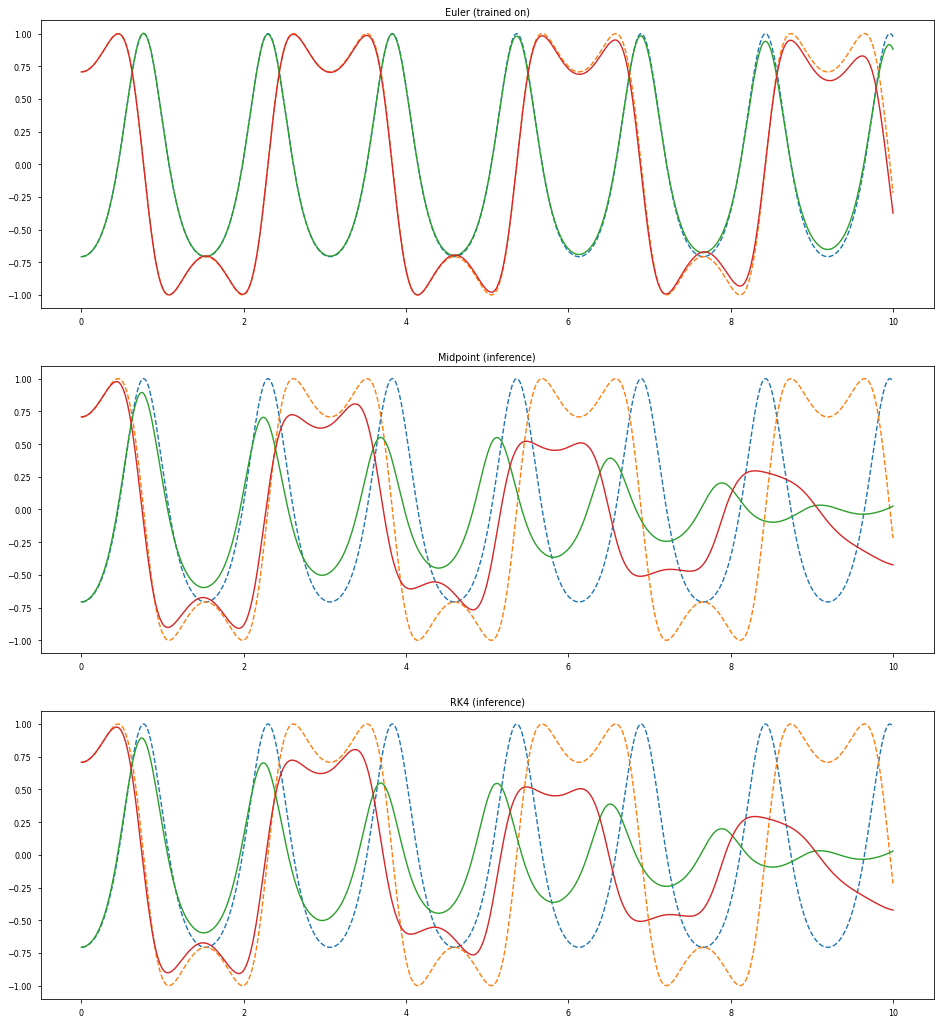

In [173]:
plt.figure(figsize=(plotting.FIG_SIZE_FULL[0],plotting.FIG_SIZE_FULL[1]*3))
plt.subplot(3,1,1)
plt.title("Euler (trained on)")
solve_and_plot(model_neuralode,'euler')
plt.subplot(3,1,2)
plt.title("Midpoint (inference)")
solve_and_plot(model_neuralode,'midpoint')
plt.subplot(3,1,3)
plt.title("RK4 (inference)")
solve_and_plot(model_neuralode,'rk4')

## Correctly learn the dynamics

In [148]:
def train_a_neural_ode_multi_method(data, ts, model=None, batch_size=25, n_future=1, 
                       learning_rate = 1.0e-4,
                       verbose=False, device=None, methods=('euler','midpoint','rk4')):
    if device is None:
        device = get_device()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    N_iter = 50000
    N_print, N_trace = N_iter, 100
    for itr in range(1, N_iter):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch(data, ts,
                                               batch_size, n_future+1)
        
        pred_y = torchdiffeq.odeint(model, batch_y0, batch_t,
                                    method=methods[0])
        loss = torch.mean(torch.abs(pred_y - batch_y))
        for met in methods[1:]:
            pred_y = torchdiffeq.odeint(model, batch_y0, batch_t,
                                    method=met)
            loss += torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        if itr % 1000 == 0:
            with torch.no_grad():
                pred_y = torchdiffeq.odeint(model, batch_y0, batch_t)
                loss = torch.mean(torch.abs(pred_y - batch_y))
    return model,np.array(losses)

In [149]:
model_multi=ODE_Func(4, hidden=50).double()

In [150]:
model_multi,losses = train_a_neural_ode_multi_method(torch_data,torch_ts, model=model_multi, device=device, batch_size=25)

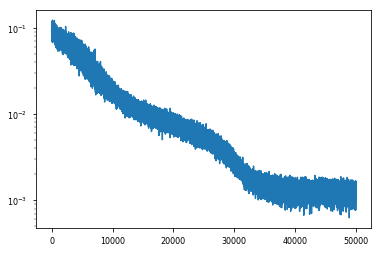

In [151]:
plt.semilogy(losses)

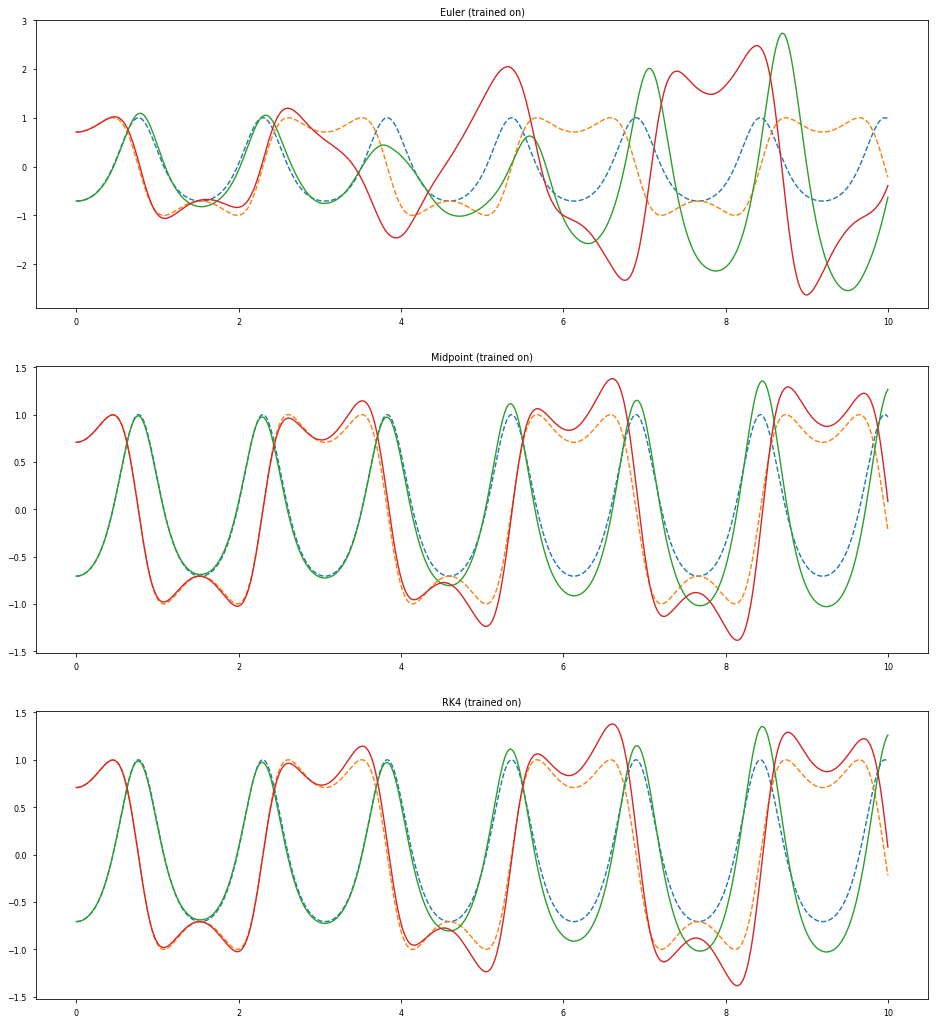

In [174]:
plt.figure(figsize=(plotting.FIG_SIZE_FULL[0],plotting.FIG_SIZE_FULL[1]*3))
plt.subplot(3,1,1)
plt.title("Euler (trained on)")
solve_and_plot(model_multi,'euler')
plt.subplot(3,1,2)
plt.title("Midpoint (trained on)")
solve_and_plot(model_multi,'midpoint')
plt.subplot(3,1,3)
plt.title("RK4 (trained on)")
solve_and_plot(model_multi,'rk4')

# Compare the results

In [350]:
ys = [ [0,1,0,0], [1,0,0,0], [np.sqrt(2),np.sqrt(2),0,0], [np.sqrt(2),-np.sqrt(2),0,0],  ]
for y in ys:
    y = data_to_torch([y],device=device)
    print(FTrue(0,y).detach().numpy())
    print(model_multi(0,y).detach().numpy())
    print(model_neuralode(0,y).detach().numpy())
    print()

[[ 0.    0.    9.81 -0.  ]]
[[ 0.07372961 -0.04148617 -1.42552288 -8.84952317]]
[[ 0.26111053 -0.2223282  -2.27534087 -9.0609527 ]]

[[ 0.  0.  0. -0.]]
[[  0.0982639   -0.30855737 -25.23486519  -2.24264651]]
[[  0.26319153  -0.25931616 -24.60033476  -2.04107228]]

[[  0.     0.    -9.81 -19.62]]
[[  0.15091852  -0.28507536 -37.16552464 -40.92386593]]
[[  0.54601815  -0.54505144 -36.56608475 -35.23111053]]

[[ 0.    0.   -9.81 19.62]]
[[  0.19424951  -0.24537617 -35.91966468  33.04618353]]
[[  0.13691394   0.39780846 -34.77603909  31.10221374]]

